In [2]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
! kaggle datasets download divg07/casia-20-image-tampering-detection-dataset

100% 2.55G/2.56G [01:28<00:00, 37.2MB/s]
100% 2.56G/2.56G [01:29<00:00, 30.8MB/s]


In [4]:
! unzip casia-20-image-tampering-detection-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: CASIA2/Tp/Tp_D_CRN_M_N_arc00045_arc00046_10084.tif  
  inflating: CASIA2/Tp/Tp_D_CRN_M_N_arc00045_arc00071_10087.tif  
  inflating: CASIA2/Tp/Tp_D_CRN_M_N_arc00046_arc00045_10083.tif  
  inflating: CASIA2/Tp/Tp_D_CRN_M_N_arc00054_cha00085_11922.jpg  
  inflating: CASIA2/Tp/Tp_D_CRN_M_N_arc00071_arc00045_10085.tif  
  inflating: CASIA2/Tp/Tp_D_CRN_M_N_arc00073_arc00072_10267.tif  
  inflating: CASIA2/Tp/Tp_D_CRN_M_N_arc00088_arc00064_10394.tif  
  inflating: CASIA2/Tp/Tp_D_CRN_M_N_art00012_art00013_11812.jpg  
  inflating: CASIA2/Tp/Tp_D_CRN_M_N_art00014_art00013_11836.jpg  
  inflating: CASIA2/Tp/Tp_D_CRN_M_N_art00058_art00049_10529.tif  
  inflating: CASIA2/Tp/Tp_D_CRN_M_N_art00067_ani00093_11801.jpg  
  inflating: CASIA2/Tp/Tp_D_CRN_M_N_art00067_ani00095_11803.jpg  
  inflating: CASIA2/Tp/Tp_D_CRN_M_N_art00067_ani00096_11802.jpg  
  inflating: CASIA2/Tp/Tp_D_CRN_M_N_art00067_nat00013_11804.jpg  
  inflating: CASIA2/Tp/Tp

DATA PREPROCESSING 



In [5]:

import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import pickle as pkl
from keras.utils.vis_utils import plot_model
import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from PIL import Image, ImageChops, ImageEnhance
from sklearn.utils import shuffle
import tensorflow as tf

#### Analysis on fake images 

In [6]:
fake_image_data={'image_path':[],'label':[],'image_id':[]}

In [7]:
fake_image_path='/content/CASIA2/Tp'
for img in os.listdir(fake_image_path) :
    if img.endswith('jpg') or img.endswith('png') :
      temp_path=fake_image_path+"/"+str(img)
      fake_image_data['image_path'].append(temp_path)
      fake_image_data['label'].append('fake')
      fake_image_data['image_id'].append(img[:-4])
    
    

In [8]:
fake_image_data=pd.DataFrame(fake_image_data)
fake_image_data.head()

,image_path,label,image_id
0,/content/CASIA2/Tp/Tp_S_CRN_M_N_pla00086_pla00...,fake,Tp_S_CRN_M_N_pla00086_pla00086_10626
1,/content/CASIA2/Tp/Tp_D_NRN_M_N_nat00033_cha00...,fake,Tp_D_NRN_M_N_nat00033_cha00070_11476
2,/content/CASIA2/Tp/Tp_D_NRN_L_N_nat00062_nat00...,fake,Tp_D_NRN_L_N_nat00062_nat00059_11108
3,/content/CASIA2/Tp/Tp_S_NNN_S_N_ind00089_ind00...,fake,Tp_S_NNN_S_N_ind00089_ind00089_10658
4,/content/CASIA2/Tp/Tp_D_CRN_S_N_ani10120_sec00...,fake,Tp_D_CRN_S_N_ani10120_sec00098_11614


In [9]:
print("Number of fake images are {}".format(fake_image_data.shape[0]))

Number of fake images are 2064


#### Analysis on Real images

In [10]:
real_image_data={'image_path':[],'label':[],'image_id':[]}

In [11]:
real_image_path='/content/CASIA2/Au'
for img in os.listdir(real_image_path) :
    if img.endswith('jpg') or img.endswith('png') :
      temp_path=real_image_path+"/"+str(img)
      real_image_data['image_path'].append(temp_path)
      real_image_data['label'].append('real')
      real_image_data['image_id'].append(img[:-4])
    
    

In [12]:
real_image_data=pd.DataFrame(real_image_data)
real_image_data.head()

,image_path,label,image_id
0,/content/CASIA2/Au/Au_art_30354.jpg,real,Au_art_30354
1,/content/CASIA2/Au/Au_cha_30238.jpg,real,Au_cha_30238
2,/content/CASIA2/Au/Au_cha_30706.jpg,real,Au_cha_30706
3,/content/CASIA2/Au/Au_arc_30418.jpg,real,Au_arc_30418
4,/content/CASIA2/Au/Au_arc_00035.jpg,real,Au_arc_00035


In [13]:
print("Number of real images are {}".format(real_image_data.shape[0]))

Number of real images are 7437


In [14]:
real_image_data=shuffle(real_image_data,random_state=42)
real_image_data=real_image_data.iloc[:fake_image_data.shape[0],:]

In [15]:
final_image_data=pd.concat([fake_image_data,real_image_data])

In [16]:
print("Total number of images in dataset is {}".format(final_image_data.shape[0]))

Total number of images in dataset is 4128


##### IMAGE PREPROCESSING (ERROR LEVEL ANALYSIS)

In [ ]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file.jpg'
    ela_filename = 'temp_ela_file.png'
    
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image

In [ ]:
image_size = (128, 128)

def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 85).resize(image_size)).flatten() / 255.0

In [ ]:
X=[]
Y=[]

In [ ]:
for index,rows in tqdm(final_image_data.iterrows()) :
    temp_ela_image=prepare_image(rows['image_path'])
    X.append(temp_ela_image)
    if rows['label']=='fake' :
        Y.append(0)
    else :
        Y.append(1)

4128it [01:15, 54.75it/s]


In [ ]:
X, Y = shuffle(X, Y, random_state=42)

In [ ]:
X = np.array(X)
X = X.reshape(-1, 128, 128, 3)

TRAINING AND VALIDATION SET

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=42)

#### CUSTOM DATAGENERATOR

In [ ]:
class Dataset:
    def __init__(self, data_x,data_y):
        self.x = []
        self.y = []
        
        for img in data_x :
            self.x.append(img)
        
        for lab in data_y :
            self.y.append(lab)
            

    def __getitem__(self, i):
            
        return self.x[i],self.y[i]
        

    def __len__(self): 
        return len(self.x)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1,shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle=shuffle
        self.indexes = np.arange(len(self.dataset.x))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        #batch = [for samples in zip(*data)]
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]

        return tuple([batch[0],batch[1]])

    def __len__(self):  
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

train_dataset=Dataset(X_train,Y_train)
train_dataloader = Dataloder(train_dataset, batch_size=8,shuffle=True)

In [ ]:
test_dataset=Dataset(X_val,Y_val)
test_dataloader = Dataloder(test_dataset, batch_size=8,shuffle=True)

#### MODEL BUILDING AND TRAINING

In [ ]:
from tensorflow.keras.layers import * 
from tensorflow.keras.models import *

In [ ]:
Input_shape=Input(shape=(128,128,3))
conv11=Conv2D(filters=128,kernel_size=(3,3),padding="same", activation="relu")(Input_shape)
conv12=Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu")(conv11)
conv13=MaxPool2D(pool_size=(2,2),strides=(2,2))(conv12)
conv13=Dropout(0.3)(conv13)


flatten1=Flatten()(conv13)
dense1=Dense(units=16,activation="relu")(flatten1)
dense2=Dense(units=8,activation="relu")(dense1)
output=Dense(units=1, activation="sigmoid")(dense2)

model=Model(inputs=Input_shape,outputs=output)
print(model.summary())



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 128)     3584      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      73792     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 64)        0         
                                                                 
 flatten (Flatten)           (None, 262144)            0         
                                                             

In [ ]:
model.compile(optimizer =tf.keras.optimizers.Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

##### Training the model

In [ ]:
def scheduler(epoch,lr) :
  if epoch%5==0 :
    lr=0.9*lr
  
  return lr

In [ ]:
#Callbacks 
lrScheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
es=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=3)
rl=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.1,patience=5)

In [ ]:
history=model.fit_generator(train_dataloader,steps_per_epoch=len(train_dataloader)//8,validation_data=test_dataloader,validation_steps=len(test_dataloader)//8,epochs=30,callbacks=[lrScheduler,es,rl])

<ipython-input-40-ac15b3a9a262>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_dataloader,steps_per_epoch=len(train_dataloader)//8,validation_data=test_dataloader,validation_steps=len(test_dataloader)//8,epochs=30,callbacks=[lrScheduler,es,rl])


Epoch 1/30
51/51 [==============================] - 14s 30ms/step - loss: 0.6479 - accuracy: 0.5417 - val_loss: 0.6496 - val_accuracy: 0.4792 - lr: 9.0000e-05
Epoch 2/30
51/51 [==============================] - 1s 26ms/step - loss: 0.6411 - accuracy: 0.4902 - val_loss: 0.6214 - val_accuracy: 0.5312 - lr: 9.0000e-05
Epoch 3/30
51/51 [==============================] - 1s 28ms/step - loss: 0.5787 - accuracy: 0.5613 - val_loss: 0.5768 - val_accuracy: 0.6354 - lr: 9.0000e-05
Epoch 4/30
51/51 [==============================] - 1s 26ms/step - loss: 0.5138 - accuracy: 0.7451 - val_loss: 0.5426 - val_accuracy: 0.8021 - lr: 9.0000e-05
Epoch 5/30
51/51 [==============================] - 1s 28ms/step - loss: 0.4964 - accuracy: 0.8015 - val_loss: 0.5109 - val_accuracy: 0.8125 - lr: 9.0000e-05
Epoch 6/30
51/51 [==============================] - 1s 28ms/step - loss: 0.4541 - accuracy: 0.8431 - val_loss: 0.5195 - val_accuracy: 0.7604 - lr: 8.1000e-05
Epoch 7/30
51/51 [==============================] -

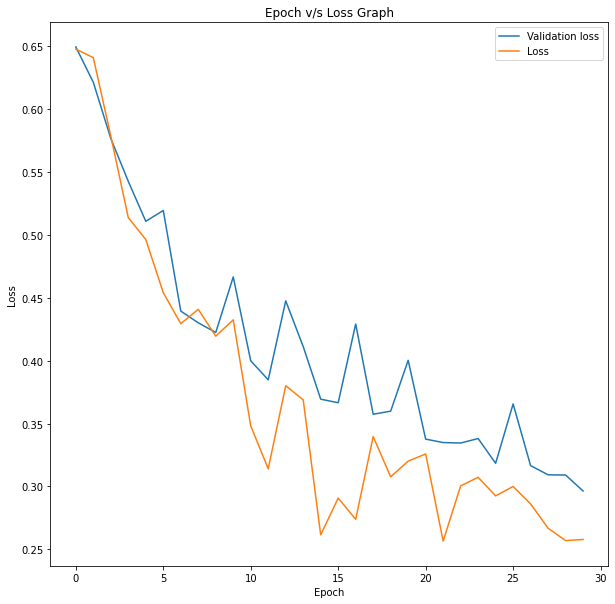

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(history.history['val_loss'],label='Validation loss')
plt.plot(history.history['loss'],label='Loss')
plt.title("Epoch v/s Loss Graph")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
model.save_weights("v1model.h5")

##### PREDICTION

In [ ]:
def predict(img_path,model) :
    pi=prepare_image(img_path)
    pi=pi.reshape(1,128,128,3)
    predict=model.predict(pi)
    return predict

In [ ]:
#Prediction on 5 random images 
for i in range(1,6) :
  ran_num=np.random.randint(0,final_image_data.shape[0])
  temp_row=final_image_data.iloc[ran_num,:]
  print("="*100)
  temp_arr=plt.imread(temp_row['image_path'])
  print("Real label--- {}".format(temp_row['label']))
  temp_predict=predict(temp_row['image_path'],model)
  if temp_predict[0]>0.5 :
    temp_prediction='real'
  else:
    temp_prediction='fake'
  print("Predicted label--- {}".format(temp_prediction))


Real label--- real
1/1 [==============================] - 0s 198ms/step
Predicted label--- real
Real label--- fake
1/1 [==============================] - 0s 20ms/step
Predicted label--- fake
Real label--- real
1/1 [==============================] - 0s 19ms/step
Predicted label--- real
Real label--- real
1/1 [==============================] - 0s 18ms/step
Predicted label--- real
Real label--- real
1/1 [==============================] - 0s 24ms/step
Predicted label--- real


In [ ]:
! pip install segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 4.4 MB/s eta 0:00:00


In [ ]:
!pip install -U -q segmentation-models
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from tensorflow.keras.optimizers import *
import segmentation_models as sm
%load_ext tensorboard
import datetime

In [ ]:
fake_image_data={'image_path':[],'label':[],'image_id':[]}

In [ ]:
fake_image_data={'image_path':[],'label':[],'image_id':[]}

fake_image_path='/content/CASIA2/Tp'
for img in os.listdir(fake_image_path) :
    if img.endswith('jpg') or img.endswith('png') :
      temp_path=fake_image_path+"/"+str(img)
      fake_image_data['image_path'].append(temp_path)
      fake_image_data['label'].append('fake')
      fake_image_data['image_id'].append(img[:-4])


In [ ]:
fake_image_data=pd.DataFrame(fake_image_data)
fake_image_data.head()

,image_path,label,image_id
0,/content/CASIA2/Tp/Tp_D_NRN_S_N_arc00059_cha00...,fake,Tp_D_NRN_S_N_arc00059_cha00062_11824
1,/content/CASIA2/Tp/Tp_D_NNN_S_N_ind00070_ind00...,fake,Tp_D_NNN_S_N_ind00070_ind00074_10930
2,/content/CASIA2/Tp/Tp_D_NRN_S_N_ind00087_ani10...,fake,Tp_D_NRN_S_N_ind00087_ani10123_11775
3,/content/CASIA2/Tp/Tp_S_NNN_S_N_cha10181_cha10...,fake,Tp_S_NNN_S_N_cha10181_cha10181_12296
4,/content/CASIA2/Tp/Tp_S_NNN_S_N_art10016_art10...,fake,Tp_S_NNN_S_N_art10016_art10016_20100


In [ ]:
print("Number of fake images are {}".format(fake_image_data.shape[0]))

Number of fake images are 2064


In [ ]:
fake_image_mask={'image_id':[],'mask_image_path':[]}
fake_image_mask_path='/content/CASIA2/CASIA 2 Groundtruth'
for file in os.listdir(fake_image_mask_path):
    if file.endswith('jpg') or file.endswith('png') :
      temp_path=fake_image_mask_path+"/"+str(file)
      fake_image_mask['mask_image_path'].append(temp_path)
      fake_image_mask['image_id'].append(file[:-7])

In [ ]:
fake_image_mask={'image_id':[],'mask_image_path':[]}
fake_image_mask_path='/content/CASIA2/CASIA 2 Groundtruth'
for file in os.listdir(fake_image_mask_path):
    if file.endswith('jpg') or file.endswith('png') :
      temp_path=fake_image_mask_path+"/"+str(file)
      fake_image_mask['mask_image_path'].append(temp_path)
      fake_image_mask['image_id'].append(file[:-7])
fake_image_mask=pd.DataFrame(fake_image_mask)
fake_image_mask.head()

,image_id,mask_image_path
0,Tp_S_NRN_S_N_sec20020_sec20020_01610,/content/CASIA2/CASIA 2 Groundtruth/Tp_S_NRN_S...
1,Tp_S_CNN_M_N_cha00078_cha00078_11027,/content/CASIA2/CASIA 2 Groundtruth/Tp_S_CNN_M...
2,Tp_S_NNN_M_N_sec00009_sec00009_10859,/content/CASIA2/CASIA 2 Groundtruth/Tp_S_NNN_M...
3,Tp_S_NNN_S_N_sec20034_sec20034_01624,/content/CASIA2/CASIA 2 Groundtruth/Tp_S_NNN_S...
4,Tp_D_NNN_S_O_nat10146_pla00049_11993,/content/CASIA2/CASIA 2 Groundtruth/Tp_D_NNN_S...


In [ ]:
fake_image_data=fake_image_data.merge(fake_image_mask,on='image_id')

In [ ]:
fake_image_data.tail()

,image_path,label,image_id,mask_image_path
1999,/content/CASIA2/Tp/Tp_S_CNN_M_N_cha00078_cha00...,fake,Tp_S_CNN_M_N_cha00078_cha00078_11027,/content/CASIA2/CASIA 2 Groundtruth/Tp_S_CNN_M...
2000,/content/CASIA2/Tp/Tp_D_NRN_S_B_cha00036_cha00...,fake,Tp_D_NRN_S_B_cha00036_cha00070_11738,/content/CASIA2/CASIA 2 Groundtruth/Tp_D_NRN_S...
2001,/content/CASIA2/Tp/Tp_S_CNN_M_N_ind00018_ind00...,fake,Tp_S_CNN_M_N_ind00018_ind00018_10709,/content/CASIA2/CASIA 2 Groundtruth/Tp_S_CNN_M...
2002,/content/CASIA2/Tp/Tp_D_NRN_S_N_pla10120_ani10...,fake,Tp_D_NRN_S_N_pla10120_ani10122_11607,/content/CASIA2/CASIA 2 Groundtruth/Tp_D_NRN_S...
2003,/content/CASIA2/Tp/Tp_D_NNN_M_N_ani10132_ani10...,fake,Tp_D_NNN_M_N_ani10132_ani10123_12477,/content/CASIA2/CASIA 2 Groundtruth/Tp_D_NNN_M...


In [ ]:
print("Total number of fake images are {}".format(fake_image_data.shape[0]))

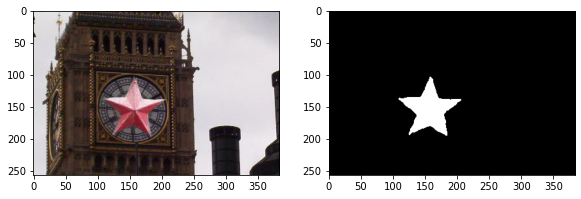

In [ ]:
ran_num=np.random.randint(0,fake_image_data.shape[0])
fig=plt.figure(figsize=(15,15))
ax1=fig.add_subplot(131)
ax2=fig.add_subplot(132)
temp_arr=Image.open(fake_image_data.iloc[ran_num]['image_path'])
temp_mask_arr=cv2.imread(fake_image_data.iloc[ran_num]['mask_image_path'],0)
ax1.imshow(temp_arr)
ax2.imshow(temp_mask_arr,cmap='gray')


In [ ]:
def change_pixel_value(A) :
    if len(A.shape)==3 :
        A=A[:,:,0]
    #Intilize a array B 
    B=np.zeros((A.shape[0],A.shape[1]))
    for i in range(A.shape[0]) :
        for j in range(A.shape[1]) :
            if A[i][j]==255 :
                B[i][j]=0.0 
            else :
                B[i][j]=1.0
    return B

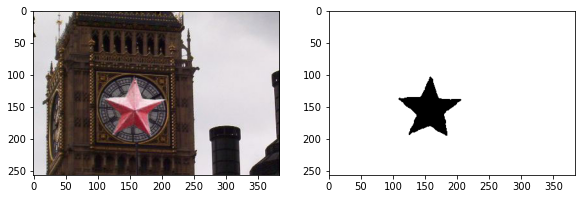

In [ ]:
fig=plt.figure(figsize=(15,15))
ax1=fig.add_subplot(131)
ax2=fig.add_subplot(132)
temp_mask_arr_mod=change_pixel_value(temp_mask_arr)
ax1.imshow(temp_arr)
ax2.imshow(temp_mask_arr_mod,cmap='gray')